In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, SVHN
import torch.utils.data as data_util

In [2]:
CUDA = torch.cuda.is_available()
print(CUDA)
device = torch.device('cuda:0' if CUDA else 'cpu')

True


In [3]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (1.0))
])

svhn_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5),(1.0))
])

In [4]:
download_root = './data'

train_mnist = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_mnist = MNIST(download_root, transform=mnist_transform, train=False, download=True)

In [5]:
svhn = SVHN(download_root, transform=svhn_transform, download=True)

Using downloaded and verified file: ./data\train_32x32.mat


In [6]:
# target domain 데이터 train 6만개, test 1만개 활용
train_indices = torch.arange(0, 60000)
test_indices = torch.arange(60000,70000)
train_svhn = data_util.Subset(svhn, train_indices)
test_svhn = data_util.Subset(svhn, test_indices)

### 모델 구조 선언

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.CNN1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1)
        self.CNN2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1)
        self.fc = nn.Linear(4 * 4 *20, 100)
        
    def forward(self, x):
        x = F.relu(self.CNN1(x)) # (batch, 1, 28, 28) -> (batch, 10, 24, 24)
        x = F.max_pool2d(x ,kernel_size=2, stride=2) # (batch, 10, 24, 24) -> (batch, 10, 12, 12)
        x = F.relu(self.CNN2(x)) # (batch, 10, 12, 12) -> (batch, 20, 8, 8)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # (batch, 20, 8, 8) -> (batch, 20, 4, 4)
        x = x.view(-1, 4 * 4 * 20) # (batch, 20, 4, 4) -> (batch, 320)
        x = F.relu(self.fc(x)) # (batch, 320) -> (batch, 100)
        return x # (batch, 100)

In [9]:
class GradReverse(torch.autograd.Function):
    def forward(self, x):
        return x.view_as(x)
    
    def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
        return (grad_output * -1)    

In [10]:
class doamin_classifier(nn.Module):
    def __init__(self):
        super(doamin_classifier, self).__init__()
        self.fc1 = nn.Linear(100, 10)
        self.fc2 = nn.Linear(10, 1) # mnist = 0, svhn = 1
        
    def forward(self, x):
        x = GradReverse.apply(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)

In [11]:
class label_classifier(nn.Module):
    def __init__(self):
        super(label_classifier, self).__init__()
        self.fc1 = nn.Linear(100, 25)
        self.fc2 = nn.Linear(25, 10) # class 개수 = 10개

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
class DANN(nn.Module):
    def __init__(self, CNN):
        super(DANN, self).__init__()
        self.cnn = CNN # CNN 구조 받아오기
        self.domain_classifier = doamin_classifier() # domain_classifier 받아오기
        self.label_classifier = label_classifier() # label_classifier 받아오기
        
    def forward(self, img):
        cnn_output = self.cnn(img) # (batch, 100)
        domain_logits = self.domain_classifier(cnn_output) # (batch, 100) -> (batch, 1)
        label_logits = self.label_classifier(cnn_output) # (batch, 100) -> (batch, 10)
        return domain_logits, label_logits

### loss 함수 선언

In [13]:
class DANN_loss(nn.Module):
    def __init__(self):
        super(DANN_loss, self).__init__()
        self.CE = nn.CrossEntropyLoss() # 0~9 분류용
        self.BCE = nn.BCELoss() # 도메인 분류용
        
    # result : DANN_CNN에서 반환된 값
    # label : 숫자 0 ~ 9에 대한 라벨
    # domain_num : 0(mnist) or 1(svhn)
    def forward(self, result, label, domain_num, alpha=1):
        domain_logits, label_logits = result
        batch_size = domain_logits.shape[0]
        domain_target = torch.FloatTensor([domain_num] * batch_size).unsqueeze(1).to(device)
        domain_loss = self.BCE(domain_logits, domain_target)
        target_loss = self.CE(label_logits, label)
        loss = domain_loss + target_loss * alpha
        return loss

### Training

In [14]:
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader

batch = 64

# dataloader 선언
mnist_loader = DataLoader(dataset=train_mnist, batch_size=batch, shuffle=True)
svhn_loader = DataLoader(dataset=train_svhn, batch_size=batch, shuffle=True)

my_cnn = CNN()
model = DANN(my_cnn).to(device)
loss_fn = DANN_loss().to(device)

epochs = 10
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=epochs * len(mnist_loader))

alpha = 0.5

for i in range(1, epochs + 1):
    total_loss = 0
    for step in tqdm(range(len(mnist_loader))):
        # mnist, svhn에서 1 batch씩 가져오기
        source_data = next(iter(mnist_loader))
        target_data = next(iter(svhn_loader))
        
        # 각 batch 내 데이터 : 0번은 이미지 픽셀 값, 1번은 0~9 class 라벨 값
        mnist_data = source_data[0].to(device)
        mnist_target = source_data[1].to(device)
        
        svhn_data = target_data[0].to(device)
        svhn_target = target_data[1].to(device)
        
        # 순전파 결과 구하기
        source_result = model(mnist_data)
        target_result = model(svhn_data)
        #print(source_result[0].shape) # 0: reg_logits torch.Size([64, 1])
        #print(source_result[1].shape) # 1: cla_logits torch.Size([64, 10])
        #print(target_result[0].shape) # 0: reg_logits torch.Size([64, 1])
        #print(target_result[1].shape) # 1: cla_logits torch.Size([64, 10])
        # 순전파 결과, class_label, domain_label, alpha 순
        source_loss = loss_fn(source_result, mnist_target, 0 , alpha = alpha)
        target_loss = loss_fn(target_result, svhn_target, 1, alpha = alpha)
        
        loss = source_loss + target_loss
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    print('Epoch : %d, Avg Loss : %.4f'%(i, total_loss / len(mnist_loader)))

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 1, Avg Loss : 3.6649


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 2, Avg Loss : 3.0013


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 3, Avg Loss : 2.5671


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 4, Avg Loss : 2.2719


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 5, Avg Loss : 2.1763


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 6, Avg Loss : 2.1471


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 7, Avg Loss : 2.1574


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 8, Avg Loss : 2.1437


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 9, Avg Loss : 2.0087


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 10, Avg Loss : 2.1870


### CLASS 분류 정확도 성능 테스트

In [15]:
batch_size = 64

mnist_loader_test = DataLoader(dataset=test_mnist, batch_size=batch_size)
svhn_loader_test = DataLoader(dataset=test_svhn, batch_size=batch_size)

model.eval() # 테스트 모드로 전환

m_correct = 0
s_correct = 0

for step in tqdm(range(len(mnist_loader_test))):
    source_data = next(iter(mnist_loader_test))
    target_data = next(iter(svhn_loader_test))
    
    mnist_data = source_data[0].to(device)
    mnist_target = source_data[1].to(device)
    
    svhn_data = target_data[0].to(device)
    svhn_target = target_data[1].to(device)
    
    # domain 분류와 관련도니 logits은 사용하지 않기에 _로 받앗 ㅓ처리
    _, mnist_logits = model(mnist_data)
    _, svhn_logits = model(svhn_data)
    
    # 정확도 산출을 위하여 정답 개수 누적
    m_correct += torch.sum(torch.argmax(mnist_logits, 1)==mnist_target).item()
    s_correct += torch.sum(torch.argmax(svhn_logits, 1)==svhn_target).item()
    
print('MNIST Test Acc : %.2f%%'%(m_correct * 100 / (len(mnist_loader_test) * batch_size)))
print('SVHN Test Acc : %.2f%%'%(s_correct * 100 / (len(svhn_loader_test) * batch_size)))

  0%|          | 0/157 [00:00<?, ?it/s]

MNIST Test Acc : 100.00%
SVHN Test Acc : 59.38%


### Domain Embedding Space 시각화

In [16]:
# 가장 앞 batch의 250개씩의 데이터만 샘플링
mnist_loader = DataLoader(dataset=train_mnist, batch_size=250, shuffle=True)
svhn_loader = DataLoader(dataset=train_svhn, batch_size=250, shuffle=True)

source_data = next(iter(mnist_loader))
target_data = next(iter(svhn_loader))

mnist_data = source_data[0].to(device)
mnist_target = source_data[1].to(device)

svhn_data = target_data[0].to(device)
svhn_target = target_data[1].to(device)

# 학습된 모델의 CNN 부분만 활용 (100차원 임베딩 벡터를 받아오는 과정)
mnist_vector = model.cnn(mnist_data)
svhn_vector = model.cnn(svhn_data)

In [17]:
from sklearn.manifold import TSNE

df = pd.DataFrame(np.concatenate([mnist_vector.cpu().detach().numpy(), svhn_vector.cpu().detach().numpy()]))

tsne_np = TSNE(n_components=2).fit_transform(df)
tsne_df = pd.DataFrame(tsne_np, columns=['component 0', 'component 1'])

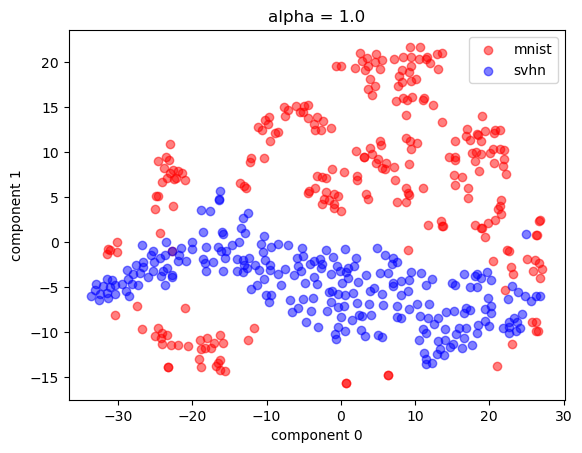

In [18]:
tsne_df_0 = tsne_df.loc[:250]
tsne_df_1 = tsne_df.loc[250:]

plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color='red', label='mnist', alpha=0.5)
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color='blue', label='svhn', alpha=0.5)

plt.title('alpha = 1.0')
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()